### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors
%matplotlib inline 
from pathlib import Path
import PIL
from PIL import Image
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms,  models
from torchsummary import summary
from tqdm import tqdm, tqdm_notebook
import pickle
import copy
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/My\ Drive/data.zip
!ls data/train
!ls data/test

0   11	14  17	2   22	25  28	30  33	36  39	41  44	47  5  8
1   12	15  18	20  23	26  29	31  34	37  4	42  45	48  6  9
10  13	16  19	21  24	27  3	32  35	38  40	43  46	49  7
0.jpeg	   1194.jpeg  1388.jpeg  228.jpeg  421.jpeg  615.jpeg  809.jpeg
1000.jpeg  1195.jpeg  1389.jpeg  229.jpeg  422.jpeg  616.jpeg  80.jpeg
1001.jpeg  1196.jpeg  138.jpeg	 22.jpeg   423.jpeg  617.jpeg  810.jpeg
1002.jpeg  1197.jpeg  1390.jpeg  230.jpeg  424.jpeg  618.jpeg  811.jpeg
1003.jpeg  1198.jpeg  1391.jpeg  231.jpeg  425.jpeg  619.jpeg  812.jpeg
1004.jpeg  1199.jpeg  1392.jpeg  232.jpeg  426.jpeg  61.jpeg   813.jpeg
1005.jpeg  119.jpeg   1393.jpeg  233.jpeg  427.jpeg  620.jpeg  814.jpeg
1006.jpeg  11.jpeg    1394.jpeg  234.jpeg  428.jpeg  621.jpeg  815.jpeg
1007.jpeg  1200.jpeg  1395.jpeg  235.jpeg  429.jpeg  622.jpeg  816.jpeg
1008.jpeg  1201.jpeg  1396.jpeg  236.jpeg  42.jpeg   623.jpeg  817.jpeg
1009.jpeg  1202.jpeg  1397.jpeg  237.jpeg  430.jpeg  624.jpeg  818.jpeg
100.jpeg   1203.jpeg  1398.jpeg  238.jpeg 

In [4]:
DATA_MODES = ['train', 'test', 'validate']
RESCALE_SIZE = 224

In [142]:
class Dogs(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        self.len_ = len(self.files)
        
        self.label_encoder = LabelEncoder()
        self.labels = [path.parent.name for path in self.files]
        

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                 pickle.dump(self.label_encoder, le_dump_file)

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
      # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        x = self.load_sample(self.files[index])
        x = transform(x)
       
        if self.mode != 'test':
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        else:
             y = str(self.files[index])
            return x, y

In [6]:
TRAIN_DIR = Path('/content/data/train/')
TEST_DIR = Path('/content/data/test/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))
assert (train_val_files and test_files)

In [7]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels)

In [ ]:
test_dataset = Dogs(test_files, mode='test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
print(len(train_val_files), 'train files')
train_val_files[:5]

7166 train files


[PosixPath('/content/data/train/0/0.jpeg'),
 PosixPath('/content/data/train/0/1.jpeg'),
 PosixPath('/content/data/train/0/10.jpeg'),
 PosixPath('/content/data/train/0/100.jpeg'),
 PosixPath('/content/data/train/0/101.jpeg')]

In [9]:
print(len(test_files), 'test files')
test_files[:5]

1503 test files


[PosixPath('/content/data/test/0.jpeg'),
 PosixPath('/content/data/test/1.jpeg'),
 PosixPath('/content/data/test/10.jpeg'),
 PosixPath('/content/data/test/100.jpeg'),
 PosixPath('/content/data/test/1000.jpeg')]

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
val_dataset = Dogs(val_files, mode='val')

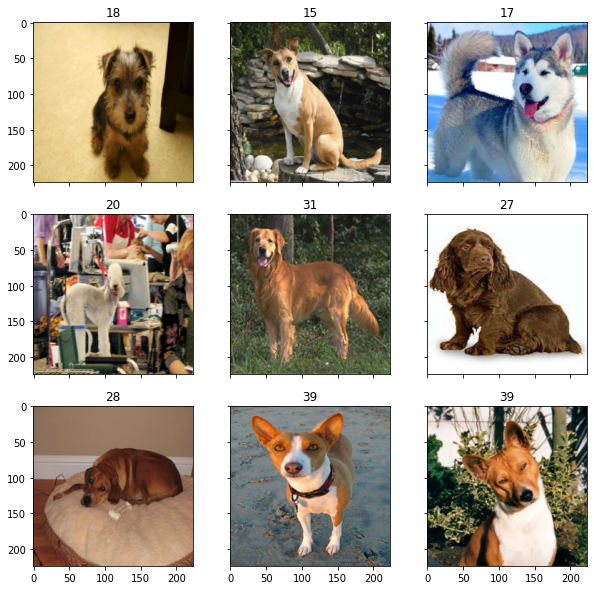

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [13]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [14]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # reset the gradient
        optimizer.zero_grad()
        
        # predictions (probabilities), loss, backprop
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # weights update
        optimizer.step()
        
        # predictions (classes)
        preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    # record train loss and train accuracy          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    # set model model into the evaluation mode (e.g. for Dropout)
    model.eval()
    
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    # record val loss and val accuracy
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_dataset, val_dataset, model, criterion,
          epochs, batch_size, optimizer, scheduler,
          shuffle=True, sampler=None, patience=5):
    
    # to record the total training time
    since = time.time()
    
    # note: 4 workers loading the data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # init variables to store best model weights, best accuracy, best epoch number, epochs since best accuracy acheived
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10
    best_epoch = 0
    epochs_since_best = 0
    
    # history and log
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(1, epochs+1):
            print(f"epoch {epoch}:\n")
            
            print("Fitting on train data...")
            # all arguments except train loader are from parameters passed to train() arguments
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("train loss:", train_loss)
            
            print("Evaluating on validation data...")
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", val_loss)
            
            # record history
            history.append((train_loss, train_acc, val_loss, val_acc.item()))
            
            # update learning rate for the optimizer
            scheduler.step()
            
            # display learning status
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # deep copy the model if it acheives the best validation performance
            if val_loss < best_loss:
                best_acc = val_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                print()
            else:
                epochs_since_best += 1
            
            # early stopping
            if epochs_since_best > patience:
                print(f'Stopping training. The validation metric has not improved for {patience} epochs.')
                break
            
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best epoch: {}'.format(best_epoch))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
            
    return history

In [170]:
def predict(model, test_loader):
    predictions = np.array([])
    names = np.array([])
 
    for inputs, file_names in test_loader:
        inputs = inputs.to(DEVICE)
        with torch.no_grad():
            outputs = model(inputs)
            probs = nn.functional.softmax(outputs, dim=-1).detach().cpu()
            probs = torch.argmax(probs, 1).numpy()
            predictions = np.append(predictions,probs)
            names = np.append(names, file_names)
            return predictions, names

In [18]:
def visualize_cost (loss_train, acc_train, loss_val, acc_val):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(12,7))
    plt.grid()
    plt.subplot(1,2,1)

    plt.plot(range(1, epochs+1), np.array(loss_train), '-o', label='Loss on train', linewidth=2)
    plt.xlabel('$Epochs$', size=20)
    plt.ylabel('$Loss$', size=20)
    plt.legend(loc='best', fontsize=20)
    
    plot2 = plt.subplot(1,2,2)
    plot2.plot(range(1, epochs+1), np.array(acc_val), '-o', label='Accuracy on val', color = 'r', linewidth=2)
    plot2.set_xlabel('$Epochs$', size=20)
    plot2.set_ylabel('$Acc$', size=20)
    plot2.legend(loc='best', fontsize=20)
    plot2.grid(True)

    plt.show()

In [19]:
N_CLASSES = len(np.unique(train_val_labels))
print("we will classify :{}".format(N_CLASSES))

we will classify :50


In [20]:
if val_dataset is None:
    val_dataset = Dogs(val_files, mode='val')
    
train_dataset = Dogs(train_files, mode='train')

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)
# change the last fc layer to our own
num_ftrs = model_resnet18.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# freeze all but 2 last layers
for param in model_resnet18.parameters():
    param.requires_grad = False
    
for param in model_resnet18.layer4.parameters():
    param.requires_grad = True
    
# requires_grad is True by default for new layer
model_resnet18.fc = torch.nn.Linear(num_ftrs, N_CLASSES)


In [ ]:
print(model_resnet18)
print(f' Total number of parameters is: {sum([param.nelement() for param in model_resnet18.parameters()])}')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

In [ ]:
model_resnet18 = model_resnet18.to(DEVICE)

In [ ]:
epochs = 10 

In [ ]:
history_resnet18 = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model_resnet18, criterion=loss_function,
                          epochs=epochs, batch_size=16, optimizer=optimizer, scheduler=scheduler)

train loss: 1.5873012494475212
Evaluating on validation data...


epoch:  10%|█         | 1/10 [00:47<07:05, 47.23s/it]

val loss: 1.1547829869983919

Epoch 001 train_loss: 1.5873     val_loss 1.1548 train_acc 0.5422 val_acc 0.6548

epoch 2:

Fitting on train data...
train loss: 1.0415895288837431
Evaluating on validation data...


epoch:  20%|██        | 2/10 [01:26<05:39, 42.45s/it]

val loss: 1.046691367940424

Epoch 002 train_loss: 1.0416     val_loss 1.0467 train_acc 0.6849 val_acc 0.6597

epoch 3:

Fitting on train data...
train loss: 0.6704288447446034
Evaluating on validation data...


epoch:  30%|███       | 3/10 [02:05<04:47, 41.01s/it]

val loss: 1.1168782036632008

Epoch 003 train_loss: 0.6704     val_loss 1.1169 train_acc 0.7905 val_acc 0.6841

epoch 4:

Fitting on train data...
train loss: 0.47944927906301665
Evaluating on validation data...


epoch:  40%|████      | 4/10 [02:45<04:02, 40.38s/it]

val loss: 1.0956139388225319

Epoch 004 train_loss: 0.4794     val_loss 1.0956 train_acc 0.8437 val_acc 0.6939

epoch 5:

Fitting on train data...
train loss: 0.33951939667125974
Evaluating on validation data...


epoch:  50%|█████     | 5/10 [03:23<03:19, 39.81s/it]

val loss: 1.121366311602471

Epoch 005 train_loss: 0.3395     val_loss 1.1214 train_acc 0.8885 val_acc 0.7273

epoch 6:

Fitting on train data...
train loss: 0.07450642791366763
Evaluating on validation data...


epoch:  60%|██████    | 6/10 [04:02<02:37, 39.46s/it]

val loss: 0.9677048894411766

Epoch 006 train_loss: 0.0745     val_loss 0.9677 train_acc 0.9770 val_acc 0.7894

epoch 7:

Fitting on train data...
train loss: 0.022054621771492866
Evaluating on validation data...


epoch:  70%|███████   | 7/10 [04:43<01:59, 39.81s/it]

val loss: 1.072433622626684

Epoch 007 train_loss: 0.0221     val_loss 1.0724 train_acc 0.9944 val_acc 0.7838

epoch 8:

Fitting on train data...
train loss: 0.00571311297997883
Evaluating on validation data...


epoch:  80%|████████  | 8/10 [05:22<01:19, 39.50s/it]

val loss: 1.2913254526889633

Epoch 008 train_loss: 0.0057     val_loss 1.2913 train_acc 0.9995 val_acc 0.7824

epoch 9:

Fitting on train data...
train loss: 0.00453262418411981
Evaluating on validation data...


epoch:  90%|█████████ | 9/10 [06:00<00:39, 39.26s/it]

val loss: 1.2900244352110464

Epoch 009 train_loss: 0.0045     val_loss 1.2900 train_acc 0.9991 val_acc 0.7810

epoch 10:

Fitting on train data...
train loss: 0.004721117115146075
Evaluating on validation data...


epoch: 100%|██████████| 10/10 [06:39<00:00, 39.94s/it]

val loss: 1.1879968145290536

Epoch 010 train_loss: 0.0047     val_loss 1.1880 train_acc 0.9984 val_acc 0.7852

Training complete in 6m 39s
Best val loss: 10.000000
Best epoch: 10


In [ ]:
train_loss, train_acc, val_loss, val_acc = zip(*history_resnet18)

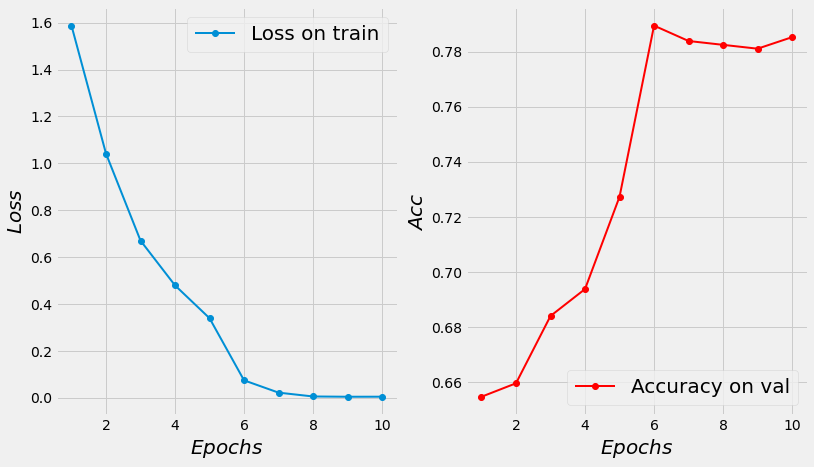

In [ ]:
visualize_cost(train_loss, train_acc, val_loss, val_acc)

In [ ]:
# Unfreeze all
for param in model_resnet18.parameters():
    param.requires_grad = True

In [ ]:
history_tune_2 = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model_resnet18, criterion=loss_function,
                          epochs=epochs, batch_size=16, optimizer=optimizer, scheduler=scheduler)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/10 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 0.2076045651805796
Evaluating on validation data...


epoch:  10%|█         | 1/10 [00:45<06:45, 45.09s/it]

val loss: 1.074384986024189

Epoch 001 train_loss: 0.2076     val_loss 1.0744 train_acc 0.9372 val_acc 0.7406

epoch 2:

Fitting on train data...
train loss: 0.10447885266588493
Evaluating on validation data...


epoch:  20%|██        | 2/10 [01:29<05:55, 44.45s/it]

val loss: 1.3522075844027175

Epoch 002 train_loss: 0.1045     val_loss 1.3522 train_acc 0.9679 val_acc 0.7294

epoch 3:

Fitting on train data...
train loss: 0.10838391959624312
Evaluating on validation data...


epoch:  30%|███       | 3/10 [02:14<05:14, 44.94s/it]

val loss: 1.4029156823565916

Epoch 003 train_loss: 0.1084     val_loss 1.4029 train_acc 0.9665 val_acc 0.7169

epoch 4:

Fitting on train data...
train loss: 0.089694912934436
Evaluating on validation data...


epoch:  40%|████      | 4/10 [02:58<04:27, 44.56s/it]

val loss: 1.207067166453791

Epoch 004 train_loss: 0.0897     val_loss 1.2071 train_acc 0.9731 val_acc 0.7357

epoch 5:

Fitting on train data...
train loss: 0.05124252767295434
Evaluating on validation data...


epoch:  50%|█████     | 5/10 [03:42<03:41, 44.34s/it]

val loss: 1.387641037690922

Epoch 005 train_loss: 0.0512     val_loss 1.3876 train_acc 0.9862 val_acc 0.6855

epoch 6:

Fitting on train data...
train loss: 0.0103260549548162
Evaluating on validation data...


epoch:  60%|██████    | 6/10 [04:26<02:57, 44.28s/it]

val loss: 1.1240921326428444

Epoch 006 train_loss: 0.0103     val_loss 1.1241 train_acc 0.9977 val_acc 0.7762

epoch 7:

Fitting on train data...
train loss: 0.0018559422487777403
Evaluating on validation data...


epoch:  70%|███████   | 7/10 [05:10<02:12, 44.25s/it]

val loss: 1.1510651232661728

Epoch 007 train_loss: 0.0019     val_loss 1.1511 train_acc 0.9997 val_acc 0.7803

epoch 8:

Fitting on train data...
train loss: 0.0015496193338812103
Evaluating on validation data...


epoch:  80%|████████  | 8/10 [05:55<01:28, 44.28s/it]

val loss: 1.1703459484245489

Epoch 008 train_loss: 0.0015     val_loss 1.1703 train_acc 0.9997 val_acc 0.7838

epoch 9:

Fitting on train data...
train loss: 0.0013187611327973299
Evaluating on validation data...


epoch:  90%|█████████ | 9/10 [06:43<00:45, 45.58s/it]

val loss: 1.1926645764657602

Epoch 009 train_loss: 0.0013     val_loss 1.1927 train_acc 0.9997 val_acc 0.7845

epoch 10:

Fitting on train data...
train loss: 0.0011071539094119345
Evaluating on validation data...


epoch: 100%|██████████| 10/10 [07:27<00:00, 44.78s/it]

val loss: 1.2340227454365589

Epoch 010 train_loss: 0.0011     val_loss 1.2340 train_acc 0.9997 val_acc 0.7782

Training complete in 7m 28s
Best val loss: 10.000000
Best epoch: 10


In [ ]:
train_loss, train_acc, val_loss, val_acc = zip(*history_tune_2)

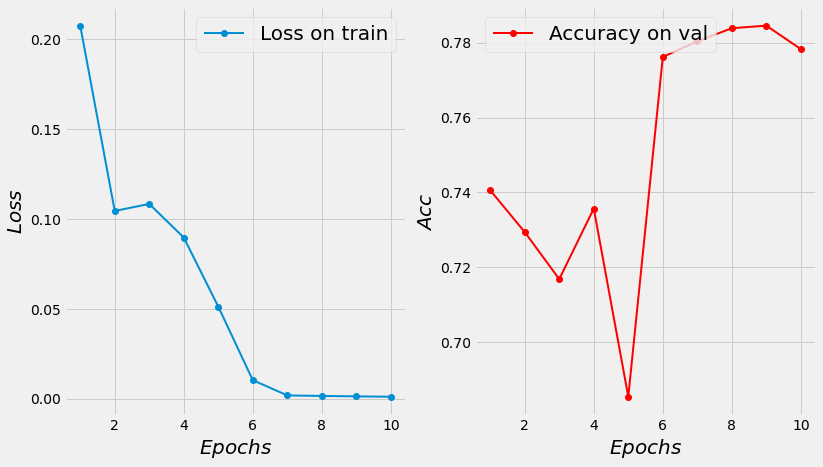

In [ ]:
visualize_cost(train_loss, train_acc, val_loss, val_acc)

In [ ]:
model_googlenet = models.googlenet(pretrained=True)
# change the last fc layer to our own
num_ftrs = model_googlenet.fc.in_features

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_googlenet.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

In [ ]:
model_googlenet = model_googlenet.to(DEVICE)

In [ ]:
# Unfreeze all
for param in model_googlenet.parameters():
    param.requires_grad = True

In [ ]:
epochs = 20

In [ ]:
model_googlenet = model_googlenet.to(DEVICE)

In [ ]:
history_tune_3 = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model_googlenet, criterion=loss_function,
                          epochs=epochs, batch_size=16, optimizer=optimizer, scheduler=scheduler)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train loss: 1.9567663099744148
Evaluating on validation data...


epoch:   5%|▌         | 1/20 [00:56<17:56, 56.66s/it]

val loss: 0.9681025585276561

Epoch 001 train_loss: 1.9568     val_loss 0.9681 train_acc 0.5209 val_acc 0.7071

epoch 2:

Fitting on train data...
train loss: 1.2406005224229901
Evaluating on validation data...


epoch:  10%|█         | 2/20 [01:52<16:47, 55.95s/it]

val loss: 1.1898374072428028

Epoch 002 train_loss: 1.2406     val_loss 1.1898 train_acc 0.6418 val_acc 0.6485

epoch 3:

Fitting on train data...
train loss: 0.6789891829419119
Evaluating on validation data...


epoch:  15%|█▌        | 3/20 [02:47<15:50, 55.89s/it]

val loss: 0.9190357990531742

Epoch 003 train_loss: 0.6790     val_loss 0.9190 train_acc 0.7920 val_acc 0.7099

epoch 4:

Fitting on train data...
train loss: 0.5201112619248288
Evaluating on validation data...


epoch:  20%|██        | 4/20 [03:43<14:50, 55.68s/it]

val loss: 0.9761841243114764

Epoch 004 train_loss: 0.5201     val_loss 0.9762 train_acc 0.8308 val_acc 0.7162

epoch 5:

Fitting on train data...
train loss: 0.39019980145370053
Evaluating on validation data...


epoch:  25%|██▌       | 5/20 [04:40<14:02, 56.17s/it]

val loss: 1.1369379360223582

Epoch 005 train_loss: 0.3902     val_loss 1.1369 train_acc 0.8719 val_acc 0.6939

epoch 6:

Fitting on train data...
train loss: 0.07309715227304847
Evaluating on validation data...


epoch:  30%|███       | 6/20 [05:35<13:03, 55.97s/it]

val loss: 0.7408651463560106

Epoch 006 train_loss: 0.0731     val_loss 0.7409 train_acc 0.9771 val_acc 0.8138

epoch 7:

Fitting on train data...
train loss: 0.018904556689503818
Evaluating on validation data...


epoch:  35%|███▌      | 7/20 [06:31<12:06, 55.91s/it]

val loss: 0.8126168191410871

Epoch 007 train_loss: 0.0189     val_loss 0.8126 train_acc 0.9963 val_acc 0.8222

epoch 8:

Fitting on train data...
train loss: 0.005112580485477935
Evaluating on validation data...


epoch:  40%|████      | 8/20 [07:27<11:10, 55.83s/it]

val loss: 0.8829725402105412

Epoch 008 train_loss: 0.0051     val_loss 0.8830 train_acc 0.9997 val_acc 0.8124

epoch 9:

Fitting on train data...
train loss: 0.0040075349647948465
Evaluating on validation data...


epoch:  45%|████▌     | 9/20 [08:23<10:14, 55.90s/it]

val loss: 0.8804962446546504

Epoch 009 train_loss: 0.0040     val_loss 0.8805 train_acc 0.9997 val_acc 0.8264

epoch 10:

Fitting on train data...
train loss: 0.0012547533213590604
Evaluating on validation data...


epoch:  50%|█████     | 10/20 [09:19<09:19, 55.95s/it]

val loss: 0.9404363120572233

Epoch 010 train_loss: 0.0013     val_loss 0.9404 train_acc 0.9998 val_acc 0.8305

epoch 11:

Fitting on train data...
train loss: 0.001587137276323118
Evaluating on validation data...


epoch:  55%|█████▌    | 11/20 [10:16<08:26, 56.33s/it]

val loss: 0.9288432573287675

Epoch 011 train_loss: 0.0016     val_loss 0.9288 train_acc 0.9998 val_acc 0.8236

epoch 12:

Fitting on train data...
train loss: 0.0010098977570492744
Evaluating on validation data...


epoch:  60%|██████    | 12/20 [11:12<07:29, 56.19s/it]

val loss: 0.9400260808908172

Epoch 012 train_loss: 0.0010     val_loss 0.9400 train_acc 0.9997 val_acc 0.8271

epoch 13:

Fitting on train data...
train loss: 0.000714666444908661
Evaluating on validation data...


epoch:  65%|██████▌   | 13/20 [12:08<06:33, 56.15s/it]

val loss: 0.9540015084368538

Epoch 013 train_loss: 0.0007     val_loss 0.9540 train_acc 0.9998 val_acc 0.8264

epoch 14:

Fitting on train data...
train loss: 0.0011284623168727043
Evaluating on validation data...


epoch:  70%|███████   | 14/20 [13:04<05:36, 56.01s/it]

val loss: 0.963294937163075

Epoch 014 train_loss: 0.0011     val_loss 0.9633 train_acc 0.9997 val_acc 0.8243

epoch 15:

Fitting on train data...
train loss: 0.0011352432044370653
Evaluating on validation data...


epoch:  75%|███████▌  | 15/20 [13:59<04:39, 55.91s/it]

val loss: 0.9747155661686344

Epoch 015 train_loss: 0.0011     val_loss 0.9747 train_acc 0.9997 val_acc 0.8250

epoch 16:

Fitting on train data...
train loss: 0.0005208408127987543
Evaluating on validation data...


epoch:  80%|████████  | 16/20 [14:57<03:45, 56.39s/it]

val loss: 0.9793630072973571

Epoch 016 train_loss: 0.0005     val_loss 0.9794 train_acc 0.9997 val_acc 0.8257

epoch 17:

Fitting on train data...
train loss: 0.0005146204779266072
Evaluating on validation data...


epoch:  85%|████████▌ | 17/20 [15:53<02:48, 56.27s/it]

val loss: 0.9877503612140831

Epoch 017 train_loss: 0.0005     val_loss 0.9878 train_acc 0.9997 val_acc 0.8243

epoch 18:

Fitting on train data...
train loss: 0.0005046509014383381
Evaluating on validation data...


epoch:  90%|█████████ | 18/20 [16:49<01:52, 56.15s/it]

val loss: 0.9978743154027306

Epoch 018 train_loss: 0.0005     val_loss 0.9979 train_acc 0.9998 val_acc 0.8257

epoch 19:

Fitting on train data...
train loss: 0.0005137244796977211
Evaluating on validation data...


epoch:  95%|█████████▌| 19/20 [17:45<00:56, 56.09s/it]

val loss: 1.0064862244376458

Epoch 019 train_loss: 0.0005     val_loss 1.0065 train_acc 0.9998 val_acc 0.8257

epoch 20:

Fitting on train data...
train loss: 0.0005706356751211747
Evaluating on validation data...


epoch: 100%|██████████| 20/20 [18:41<00:00, 56.06s/it]

val loss: 1.0160768665335982

Epoch 020 train_loss: 0.0006     val_loss 1.0161 train_acc 0.9997 val_acc 0.8264

Training complete in 18m 41s
Best val loss: 10.000000
Best epoch: 20


In [ ]:
train_loss,  train_acc, val_loss, val_acc = zip(*history_tune_3)

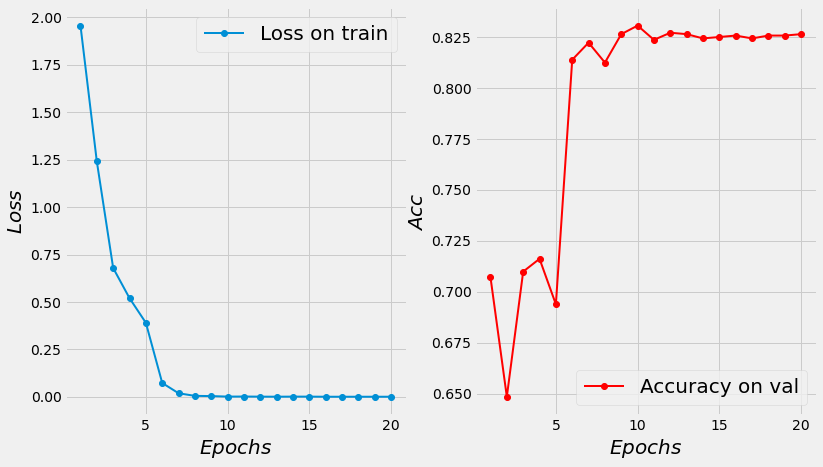

In [ ]:
visualize_cost(train_loss, train_acc, val_loss, val_acc)

In [ ]:

!pip install -q gputil
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [ ]:
printm()

Gen RAM Free: 12.2 GB  |     Proc size: 968.5 MB
GPU RAM Free: 15106MB | Used: 3MB | Util   0% | Total     15109MB


In [21]:
resnet152 = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [22]:
model_resnet152 = models.resnet152(pretrained=True)
# change the last fc layer to our own
num_ftrs = model_resnet152.fc.in_features

In [23]:

for param in model_resnet152.parameters():
    param.requires_grad = False
    
for param in model_resnet152.layer4.parameters():
    param.requires_grad = True
    
# requires_grad is True by default for new layer
model_resnet152.fc = torch.nn.Linear(num_ftrs, N_CLASSES)

In [24]:
print(model_resnet152)
print(f' Total number of parameters is: {sum([param.nelement() for param in model_resnet152.parameters()])}')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
epochs = 8

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_resnet152.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

In [26]:
model_resnet152 = model_resnet152.to(DEVICE)

In [27]:
history_tune_4 = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model_resnet152, criterion=loss_function,
                          epochs=epochs, batch_size=16, optimizer=optimizer, scheduler=scheduler)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 1.109404764804321
Evaluating on validation data...


epoch:  12%|█▎        | 1/8 [01:23<09:41, 83.10s/it]

val loss: 0.6087930159775782

Epoch 001 train_loss: 1.1094     val_loss 0.6088 train_acc 0.7003 val_acc 0.8166

epoch 2:

Fitting on train data...
train loss: 0.6950439630025597
Evaluating on validation data...


epoch:  25%|██▌       | 2/8 [02:41<08:03, 80.59s/it]

val loss: 0.9091982679574547

Epoch 002 train_loss: 0.6950     val_loss 0.9092 train_acc 0.7931 val_acc 0.7399

epoch 3:

Fitting on train data...
train loss: 0.3982459752945865
Evaluating on validation data...


epoch:  38%|███▊      | 3/8 [03:59<06:35, 79.05s/it]

val loss: 0.6814544431792476

Epoch 003 train_loss: 0.3982     val_loss 0.6815 train_acc 0.8821 val_acc 0.7950

epoch 4:

Fitting on train data...
train loss: 0.24829786254479097
Evaluating on validation data...


epoch:  50%|█████     | 4/8 [05:17<05:15, 78.83s/it]

val loss: 0.6044667556341555

Epoch 004 train_loss: 0.2483     val_loss 0.6045 train_acc 0.9204 val_acc 0.8291

epoch 5:

Fitting on train data...
train loss: 0.23551355193473728
Evaluating on validation data...


epoch:  62%|██████▎   | 5/8 [06:34<03:54, 78.26s/it]

val loss: 0.6462533678956891

Epoch 005 train_loss: 0.2355     val_loss 0.6463 train_acc 0.9238 val_acc 0.8382

epoch 6:

Fitting on train data...
train loss: 0.047044693662467184
Evaluating on validation data...


epoch:  75%|███████▌  | 6/8 [07:53<02:36, 78.29s/it]

val loss: 0.4043163552482819

Epoch 006 train_loss: 0.0470     val_loss 0.4043 train_acc 0.9848 val_acc 0.8968

epoch 7:

Fitting on train data...
train loss: 0.014576991163803878
Evaluating on validation data...


epoch:  88%|████████▊ | 7/8 [09:10<01:17, 77.97s/it]

val loss: 0.41147254073290224

Epoch 007 train_loss: 0.0146     val_loss 0.4115 train_acc 0.9958 val_acc 0.9017

epoch 8:

Fitting on train data...
train loss: 0.005231521738816215
Evaluating on validation data...


epoch: 100%|██████████| 8/8 [10:28<00:00, 78.51s/it]

val loss: 0.4641721932505838

Epoch 008 train_loss: 0.0052     val_loss 0.4642 train_acc 0.9988 val_acc 0.8968

Training complete in 10m 28s
Best val loss: 10.000000
Best epoch: 8


In [28]:
train_loss,  train_acc, val_loss, val_acc = zip(*history_tune_4)

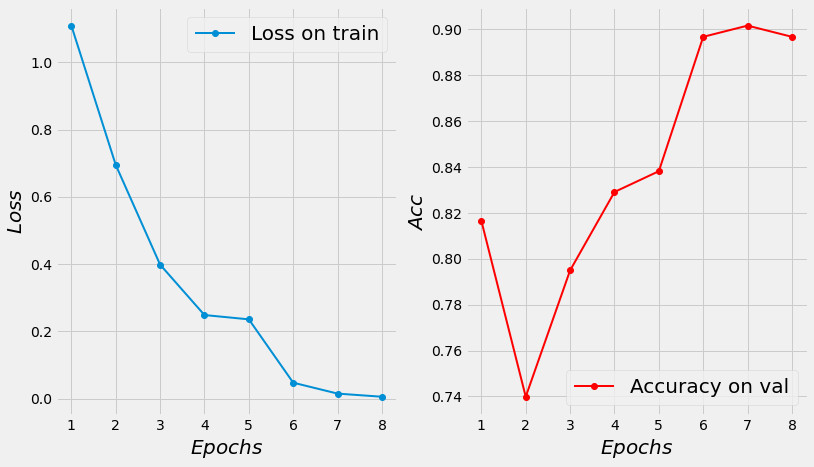

In [29]:
visualize_cost(train_loss, train_acc, val_loss, val_acc)

## Predictions

In [30]:
torch.save(model_resnet152,'drive/My Drive/model_resnet152.txt') # save

In [171]:
model_resnet152.eval()
predictions, names =  predict(model_resnet152, test_loader)

In [172]:
print(names[:5])

['/content/data/test/0.jpeg' '/content/data/test/1.jpeg'
 '/content/data/test/10.jpeg' '/content/data/test/100.jpeg'
 '/content/data/test/1000.jpeg']


In [173]:
digit_names = []
for i in names:
    digit = "".join(filter(str.isdigit, i))
    digit_names.append(digit)

In [179]:
my_submit = pd.DataFrame({'Id': digit_names, 'Expected': predictions.astype(int)})
print(my_submit.shape)
my_submit

(64, 2)


,Id,Expected
0,0,37
1,1,23
2,10,33
3,100,10
4,1000,29
...,...,...
59,1050,42
60,1051,1
61,1052,47
62,1053,25


In [180]:
my_submit.to_csv('Samarin_submission.csv', index=False) 

## Conclusion
* I used different pre-trained models, such as resnet18, googlenet, resnet152, trained in different ways, all and only the last layers.

* As a result, the winner was the resnet152 neural network with 58,246,258 parameters  with accuracy on a validation sample of 0.9017

* P.S. I even had to reinstall PyTorch due to the fact that the memory of the video card was overflowing and it was not possible to clean it.))